# Assessing the Impact of Flooding on Crop Growing Conditions Using Sentinel-2 and Environmental Data

## Learning Objectives

In this notebook you will learn about the capacities of eodal to address agro-ecological research questions.

## Tutorial Pre-Requisites

This tutorial is introductorial level. Basic knowledge about [Sentinel-2](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi) is helpful but not required.

## Study Area

The Seeland is an important production location for Swiss agriculture, but it is also a rather young area: the former moorland was only made arable within the framework of the two Jura water corrections, the first of which began in 1868. The former moor soils have a high proportion of organic material, which accounts for their high fertility.

However, the use of the former moors has come at a high price: Bog subsidence and decomposition of the organic matter (accelerated humus decomposition) continuously lower the land surface in the study region. In a [study by the University of Zurich](https://doi.org/10.5167/uzh-190633) (only in German), ground subsidence of up to 2.5 m was found in a comparison of the terrain heights of 1920 and 2016. The subsidence makes the terrain close to lakes susceptible to flooding, which can affect plant growth.

This was also the case in the summer of 2021. Intense rainfall in June and July 2021 caused large-scale flooding that persisted for extended periods of time. This was also the case in the investigated plot.

In 2021, seed potatoes were grown on this plot. From the end of June, repeated rainfall led to partial flooding of the plot. The effects of this flooding were still clearly visible in the spring of 2022, where green canopy cover, tillering rate and leaf area in the cultivated winter wheat were significantly lower where the flooding lasted the longest. This area can also be clearly seen in the digital terrain model, where the soil is slightly lower (1 to 1.5m) than in the rest of the plot.

The purpose of this notebook is to show how satellite remote sensing (Sentinel-2) and mapping can be used for a simple qualitative estimate of inundation and its influence on plant growth, which in turn can be the starting point for detailed quantitative analyses.

The **map** below shows the field parcel and its location in the "Seeland" region:

In [1]:
!pip install folium

In [3]:
# load the parcel boundaries and display them using folium
import os, sys
import folium
import geopandas as gpd
import warnings

warnings.filterwarnings('ignore')

from pathlib import Path
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent

# read parcel and calculate its centroid for setting map center properly
parcel = gpd.read_file(base_dir.joinpath('data/sample_polygons/Parzelle35.shp'))
# for plotting, convert to geographic coordinates (WGS84, EPSG:4326)
parcel_wgs84 = parcel.to_crs('EPSG:4326')
parcel_centroid = parcel_wgs84.geometry.iloc[0].centroid

# create map
map = folium.Map([parcel_centroid.y, parcel_centroid.x], zoom_start=13, tiles="Stamen Terrain")
folium.GeoJson(data=parcel["geometry"]).add_to(map)

map

## Meteorological Situation in Summer 2021

Daily precipitation data interpolated from rain gauges across Switzerland from MeteoSwiss [RhiresD](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjVi9ufweP3AhWq8LsIHZABB3wQFnoECAYQAQ&url=https%3A%2F%2Fwww.meteoswiss.admin.ch%2Fcontent%2Fdam%2Fmeteoswiss%2Fde%2Fservice-und-publikationen%2Fprodukt%2Fraeumliche-daten-niederschlag%2Fdoc%2FProdDoc_RhiresD.pdf&usg=AOvVaw1g8AL4J-y43n8Yz97ZBF4V) is shown below for time between June 1st and July 31st 2021 as cumulative daily rainfall sums.

In addition, **growing degree days** (GDD) are calculated from daily minimum and maximum air temperature readings derived from [MeteoSwiss](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwji4tD4h-n3AhXp7rsIHfRyAUMQFnoECAkQAQ&url=https%3A%2F%2Fwww.meteoswiss.admin.ch%2Fcontent%2Fdam%2Fmeteoswiss%2Fde%2Fservice-und-publikationen%2Fprodukt%2Fraeumliche-daten-temperatur%2Fdoc%2FProdDoc_TabsD.pdf&usg=AOvVaw2VdWnq2y9IEXzyjBL314wE).

GDDs are calculated from daily maximum ($T_{max}$) and minimum air temperature ($T_{min}$) using the formula shown below with a base temperatue ($T_{base}$) of 8 deg C as [suggested for potatoes](https://mrcc.illinois.edu/gismaps/info/gddinfo.htm):

$$
  GDD = \frac{T_{max} - T_{min}}{2} - T_{base}
$$

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# load extracted daily rainfall amounts and plot them
rain = pd.read_csv(base_dir.joinpath('data/meteo/RhiresD.csv'))
rain.date = pd.to_datetime(rain.date)
# get cumulative rainfall
rain['cumulative precipitation'] = rain['precip'].cumsum()

# load Tmin and Tmax air temperature records
tmax = pd.read_csv(base_dir.joinpath('data/meteo/TmaxD.csv'))
tmax.date = pd.to_datetime(tmax.date)
tmin = pd.read_csv(base_dir.joinpath('data/meteo/TminD.csv'))
tmin.date = pd.to_datetime(tmin.date)
# merge records
temp = pd.merge(tmax, tmin, how='outer', on='date')
# order by date
temp = temp.sort_values(by="date")
# calculate GDD
temp['GDD'] = temp.apply(lambda x: (x['TmaxD'] + x['TminD']) / 2 - 8, axis=1)
temp['cumulative GDD'] = temp['GDD'].cumsum()

#merge temperature and rain fall data
meteo = pd.merge(temp, rain, how='outer', on='date')
# skrink to June and July
meteo = meteo[meteo.date >= datetime(2021,6,1,0,0,0)]

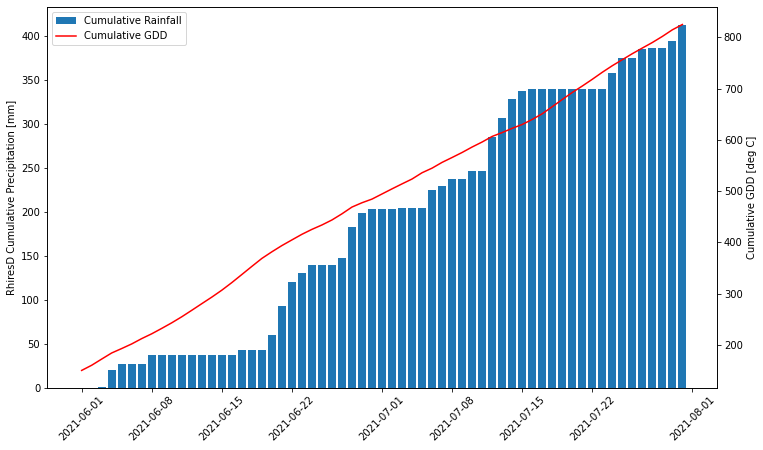

In [7]:
# plot data
f = plt.figure(figsize=(12,7))
ax = f.add_subplot(111)

meteo['Date'] = meteo.date.apply(lambda x: x.date())
ax.bar(x=meteo['Date'], height=meteo['cumulative precipitation'], label='Cumulative Rainfall')
ax2 = ax.twinx()
ax2.plot(meteo['Date'], meteo['cumulative GDD'], color='red', label='Cumulative GDD')
_ = plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_ylabel('RhiresD Cumulative Precipitation [mm]')
ax2.set_ylabel('Cumulative GDD [deg C]')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(
    lines + lines2, labels + labels2,
)

As shown in the figure above the overall sum of rain in this time was rather high:

In [8]:
import numpy as np
print(f'Precipitation Sum [mm]: {np.round(rain["precip"].sum(),1)}')

Precipitation Sum [mm]: 412.5


Between mid of June and mid of July the cumulative rain fall was around 300 mm. This is roughly three times higher than the average monthly precipitation sum  in these months.

## Impacts on Plant Growing Conditions as Seen From Space

### How it works

Optical satellite data from the Sentinel-2 mission can be used to capture the evolution of vegetation canopy over time with 10 spectral channels between 490 and 2200 nm wavelengths.

Using `eodal`, the Sentinel-2 data are automatically retrieved from a local archive, extracted and filtered per pixel for any clouds and shadows (based on the Sentinel-2 Scene Classification Layer, which originates from Sen2Cor).

The user specifies a time period and a geographic extent - in this case the parcel shown above. `eodal` then makes a spatio-temporal query, which returns a pre-selection of Sentinel-2 scene for the study region based on the location and scene-wide cloud cover. These pre-selected scenes are read in iteratively by `eodal` as a "RasterCollection", with the cloud cover calculated at the plot level. If the plot-based cloud coverage is above a user-defined threshold value, a scene is discarded.

`eodal` also checks if the extracted section contains only **blackfill (nodata)**. Especially in the study region, due to the orbit design of Sentinel-2, it often happens that a scene contains nodata to a large degree. Such scenes are then also excluded from the list of used Sentinel-2 scenes.

All scenes are provided in 10 m spatial resolution. Those Sentinel-2 bands with a coarser spatial resolution (20 m; the 60 m are not read by default) are resampled to 10 m using nearest neighbour interpolation.

In addition **two spectral vegetation indices** are calculated:
* NDVI (Normalized Difference Vegetation Index)
* MSAVI (Modified Soil-Adjusted Vegetation Index)

**NDVI** is among the most widely used vegetation indices and takes values between -1 and +1. The higher the NDVI, the greener and healthier vegetation is. NDVI, however, saturates at high biomass levels and is sensitive to (soil) background effects. **MSAVI** in contrast was designed to minimize the impact of soil background effects. Therefore, MSAVI is especially suited for early vegetation growth during emergence and leaf development.

### Sentinel-2 Data Access

The **Sentinel-2 archive** can be placed on local-premises ("offline" mode) or in a cloud-computing environment ("online" mode). In the "online" mode a Spatio-Temporal-Asset-Catalog is queried, whereas the "offline" mode relies on a geo-spatial PostgreSQL/PostGIS database.

Currently, Sentinel-2 can be derived from two online resources besides the option to download data from Copernicus or CREODIAS to local storage:

* [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) - no authentication required, tested
* [Amazon Web Services](https://aws.amazon.com/) - authentication required, partly tested

Here, we use [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) to make the notebook fully reproducible and limit the amount of data to download to a few mega bytes.

In [9]:
# set environment variable to enable working with STAC from Planetary Computer
!export USE_STAC=True

The actual Sentinel-2 data querying and reading functionality is implemented in a single below:

In [25]:
# define a function for Sentinel-2 data extraction from the archive
import cv2
import numpy as np

from datetime import date
from typing import Any, Dict

from eodal.utils.sentinel2 import ProcessingLevels
from eodal.operational.mapping import MapperConfigs
from eodal.operational.mapping.sentinel2 import Sentinel2Mapper

def extract_s2_data(
        parcel: gpd.GeoDataFrame,
        date_start: date,
        date_end: date,
        scene_cloud_cover_threshold: float = 80,
        feature_cloud_cover_threshold: float = 50,
        spatial_resolution: int = 10,
        resampling_method: int = cv2.INTER_NEAREST_EXACT
    ) -> Dict[str, Any]:
    """
    Extracts Sentinel-2 data from the STAC SAT archive for a given area and time period.
    Scenes that are too cloudy or contain nodata (blackfill), only, are discarded.

    The processing level of the Sentinel-2 data is L2A (surface reflectance factors).

    :param parcel:
        field parcel geometry (defines the spatial extent to extract)
    :param date_start:
        start of the time period to extract
    :param date_end:
        end of the time period to extract
    :param scene_cloud_cover_threshold:
        scene-wide cloudy pixel percentage (from Sentinel-2 metadata) to filter out scenes
        with too high cloud coverage values [0-100%]
    :param feature_cloud_cover_threshold:
        cloudy pixel percentage [0-100%] on the parcel level. Only if the parcel has a
        lower percentual share of cloudy pixels (based on the scene classification layer) than
        the threshold specified, the Sentinel-2 observation is kept
    :param spatial_resolution:
        spatial resolution of the Sentinel-2 data in meters (Def: 10m)
    :param resampling_method:
        spatial resampling method for those Sentinel-2 bands not available in the target
        resolution. Nearest Neighbor by default
    :returns:
        dictionary with the list of scenes for the field parcel (`feature_scenes`), the
        DataFrame of (un)used scenes and the reason for not using plus some basic scene
        metadata (`scene_properties`)
    """
    # set up mapping configs
    mapper_configs = MapperConfigs(
        spatial_resolution=spatial_resolution,
        resampling_method=resampling_method
    )

    # get a new mapper instance
    mapper = Sentinel2Mapper(
        date_start=date_start,
        date_end=date_end,
        processing_level=ProcessingLevels.L2A, # get L2A data (to get L1C, replace with ProcessingLevels.L1C)
        feature_collection=parcel,
        cloud_cover_threshold=scene_cloud_cover_threshold,
        mapper_configs=mapper_configs,
        unique_id_attribute='PARZ' # this identifies the attribute with the unique feature id
    )

    # query the STAC (looks for available scenes in the selected spatio-temporal range)
    mapper.get_scenes()

    # get observations (reads the data)
    s2_data = mapper.get_complete_timeseries()

    # extraction is based on features (1 to N field parcel geometries)
    features = mapper.feature_collection['features']

    # the data is extract per feature. Since there is only one parcel (= one feature) the feature collection
    # also only contains this single item
    feature_id = mapper.get_feature_ids()[0]
    feature_scenes = s2_data[feature_id]

    scene_props_list = []
    scene_stats_list = []
    final_scenes = {}
    # loop over available Sentinel-2 scenes
    for idx, scene in enumerate(feature_scenes):

        # collect Sentinel-2 metadata
        scene_props ={
            'product_uri': scene.scene_properties.product_uri,
            'sensing_time': scene.scene_properties.acquisition_time,
            'feature_cloudy_pixel_percentage': np.nan
        }

        # check if scene is blackfilled (nodata); if yes continue
        if scene.is_blackfilled:
            scene_props.update({'scene_used': 'NO [Blackfill]'})
            scene_props_list.append(scene_props)
            # remove scene from list
            # feature_scenes.pop(idx)
            continue

        # check cloud coverage (including shadows and snow) of the feature
        feature_cloud_cover = scene.get_cloudy_pixel_percentage(
            cloud_classes=[3, 8, 9, 10, 11]
        )
        scene_props.update({'feature_cloudy_pixel_percentage': feature_cloud_cover})
        if feature_cloud_cover > feature_cloud_cover_threshold:
            scene_props.update({'scene_used': 'NO [Clouds]'})
            scene_props_list.append(scene_props)
            # remove scene from list
            # feature_scenes.pop(idx)
            continue

        scene_props.update({'scene_used': 'YES'})
        scene_props_list.append(scene_props)

        # mask cloudy pixels and shadows
        if feature_cloud_cover > 0:
            scene.mask_clouds_and_shadows(
                bands_to_mask=scene.band_names
            )

        # calculate the NDVI and MSAVI
        scene.calc_si('NDVI', inplace=True)
        scene.calc_si('MSAVI', inplace=True)
        stats = scene.band_summaries(
            band_selection=['NDVI'],
            methods=['nanmin', 'nanmax', 'nanmedian', 'nanmean', 'nanstd']
        )
        stats['product_uri'] = scene.scene_properties.product_uri
        stats['sensing_date'] = scene.scene_properties.acquisition_time.date()
        stats['cloudy_pixel_percentage'] = feature_cloud_cover
        scene_stats_list.append(stats)

        final_scenes[scene.scene_properties.acquisition_time.date()] = scene
    
    scene_props_df = pd.DataFrame(scene_props_list)
    scene_stats = pd.concat(scene_stats_list)

    # order by sensing date
    scene_props_df = scene_props_df.sort_values(by='sensing_time')

    return {'feature_scenes': final_scenes, 'scene_properties': scene_props_df}


In addition, a function is defined to plot a series of Sentinel-2 scenes as **near-infrared False-Color composite** plus the **MSAVI and NDVI indices** which are both proxies for canopy greeness and relate to physiological plant traits such as the **Leaf Area Index (LAI)**.

In [26]:
# plot parcel and its temporal development
def plot_images(res):
    f, axes = plt.subplots(ncols=len(res['feature_scenes']), nrows=3, figsize=(26,14))
    for idx, s2_acqui in enumerate(sorted(res['feature_scenes'].keys())):
        res['feature_scenes'][s2_acqui].plot_multiple_bands(
            band_selection=['nir_1', 'red' ,'green'],
            ax=axes[0,idx]
        )
        axes[0,idx].set_title(s2_acqui)
        axes[0,idx].set_xlabel('')
        axes[0,idx].get_xaxis().set_ticks([])
         # plot the MSAVI
        res['feature_scenes'][s2_acqui].plot_band(
            'MSAVI',
            colormap='summer',
            colorbar_label='MSAVI [-]',
            vmin=0,
            vmax=0.8,
            ax=axes[1,idx]
        )
        # plot the MSAVI
        res['feature_scenes'][s2_acqui].plot_band(
            'NDVI',
            colormap='summer',
            colorbar_label='NDVI [-]',
            vmin=0,
            vmax=1.,
            ax=axes[2,idx]
        )
        # set y and x ticks as well as title strings at the outer bounds, only, of to improve readability
        if idx > 0:
            for jdx in range(3):
                axes[jdx,idx].get_yaxis().set_ticks([])
                axes[jdx,idx].set_ylabel('')
        for jdx in range(1,3):
            for idx in range(len(res['feature_scenes'])):
                axes[jdx,idx].set_title('')
                if jdx == 1:
                    axes[jdx,idx].get_xaxis().set_ticks([])
                    axes[jdx,idx].set_xlabel('')


### Situation in Summer 2021 (before and after heave rain falls)

Data before, during and after the most heavy rainfall events is extracted between June 1st and July 31st 2021. All scenes with a cloud coverage lower than 80% and a parcel-based cloudy pixel percentage of lower than 50% are considered.

In [20]:
res_s21 = extract_s2_data(
    parcel=parcel,
    date_start=date(2021,6,1),
    date_end=date(2021,7,31)
)

2022-06-09 15:57:42,994 eodal        INFO     Feature 35: Extracted data from 2021-07-28 (1/7)
2022-06-09 15:57:45,620 eodal        INFO     Feature 35: Extracted data from 2021-07-23 (2/7)
2022-06-09 15:57:47,941 eodal        INFO     Feature 35: Extracted data from 2021-07-18 (3/7)
2022-06-09 15:57:50,682 eodal        INFO     Feature 35: Extracted data from 2021-06-23 (4/7)
2022-06-09 15:57:53,545 eodal        INFO     Feature 35: Extracted data from 2021-06-18 (5/7)
2022-06-09 15:57:56,114 eodal        INFO     Feature 35: Extracted data from 2021-06-13 (6/7)
2022-06-09 15:57:59,395 eodal        INFO     Feature 35: Extracted data from 2021-06-03 (7/7)


Overall, 7 Sentinel-2 scenes were found in the STAC. However, due to cloud coverage and blackfill only five scenes (with 0% cloud cover on the parcel level) can be used to assess the vegetation development over time. In the `res_s21['scene_properties']` `pandas.DataFrame` the column `scene_used` shows why a scene out of the overall stack of scenes found was disregarded:

In [27]:
res_s21['scene_properties']

,product_uri,sensing_time,feature_cloudy_pixel_percentage,scene_used
6,S2B_MSIL2A_20210603T102559_N0300_R108_T32TLT_2...,2021-06-03 10:25:59,92.571429,NO [Clouds]
5,S2B_MSIL2A_20210613T102559_N0300_R108_T32TLT_2...,2021-06-13 10:25:59,0.000000,YES
4,S2A_MSIL2A_20210618T103021_N0300_R108_T32TLT_2...,2021-06-18 10:30:21,0.000000,YES
3,S2B_MSIL2A_20210623T102559_N0300_R108_T32TLT_2...,2021-06-23 10:25:59,0.000000,YES
2,S2A_MSIL2A_20210718T103031_N0300_R108_T32TLT_2...,2021-07-18 10:30:31,0.000000,YES
1,S2B_MSIL2A_20210723T102559_N0300_R108_T32TLT_2...,2021-07-23 10:25:59,0.000000,YES
0,S2A_MSIL2A_20210728T103031_N0300_R108_T32TLT_2...,2021-07-28 10:30:31,97.142857,NO [Clouds]


Using the custom plot function, the near-infrared false color composite (top row), MSAVI (middle row) and NDVI (bottom row) can be displayed over time:

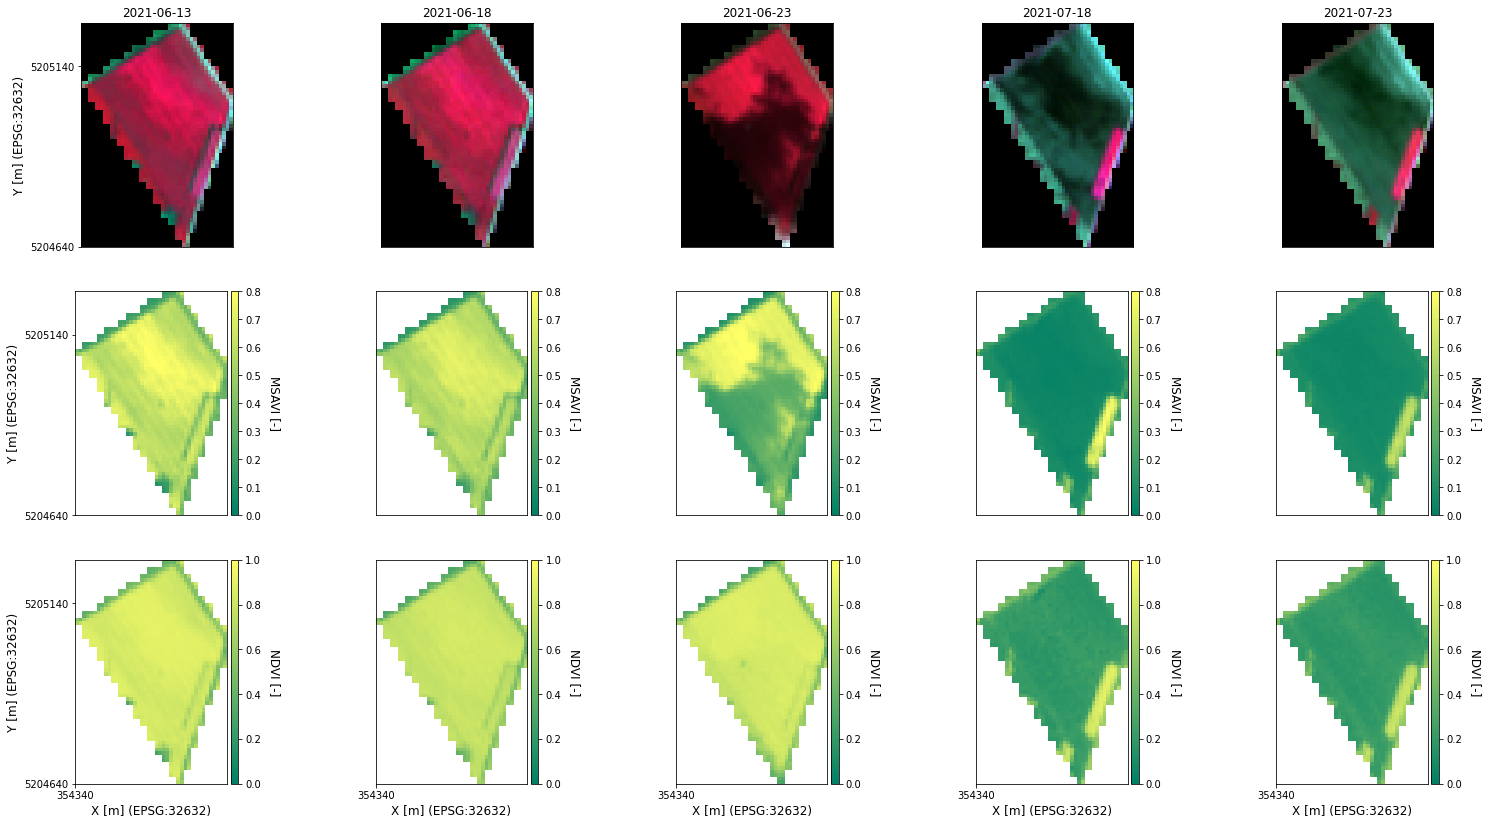

In [28]:
plot_images(res_s21)

In the false-color composite, reddish tones indicate healthy vegetation. Accordinly, high MSAVI and NDVI values indicate high biomass values. Healthy, green vegetation can be found before June 13rd 2021.

In turn, the lower the MSAVI and NDVI values and the more greenish the false-color infra-red composite, the less green and healthy vegetation is. This is clearly the case for the two Sentinel-2 scenes from July 2021.

The series in the figure above shows healthy, green vegetation for the first two Sentinel-2 images in June 2021. On the third image (2021-06-23), at the beginning of the heavy rainfalls an reduction in greeness is already visible for parts of the field. This, however, could also be the effect of an undetected cloud shadow.

For the two July scenes (right-most images), vegetation greeness is clearly lower and MSAVI has decreased to values close to zero. In addition, the scene from July 18th 2021 shows some dark areas in the central parts of the parcel. These indicate areas that were flooded and are still affected by wet and muddy conditions. On July 23rd 2021, the situation has improved since the extent of the dark is smaller.

### Situation in Early Spring 2022

In autumn 2021, winter wheat was sown. A field visit in March 2022 revealed remarkable differences in the green canopy coverage, leaf area and tillerage within the field. It turned out that those areas with low green canopy coverage, lower leaf area values and poor tillerage were bound to those area most heavily affected by the flooding in the previous year.

Also the Sentinel-2 satellite data between February 1st and March 31st 2022 shows this within-field eterogeneity clearly:

In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

res_s22 = extract_s2_data(
    parcel=parcel,
    date_start=date(2022,2,1),
    date_end=date(2022,3,31)
)

2022-06-09 15:53:56,672 eodal        INFO     Feature 35: Extracted data from 2022-03-25 (1/8)
2022-06-09 15:53:59,559 eodal        INFO     Feature 35: Extracted data from 2022-03-20 (2/8)
2022-06-09 15:54:02,501 eodal        INFO     Feature 35: Extracted data from 2022-03-10 (3/8)
2022-06-09 15:54:05,403 eodal        INFO     Feature 35: Extracted data from 2022-03-05 (4/8)
2022-06-09 15:54:08,138 eodal        INFO     Feature 35: Extracted data from 2022-02-28 (5/8)
2022-06-09 15:54:10,970 eodal        INFO     Feature 35: Extracted data from 2022-02-23 (6/8)
2022-06-09 15:54:13,984 eodal        INFO     Feature 35: Extracted data from 2022-02-13 (7/8)
2022-06-09 15:54:17,325 eodal        INFO     Feature 35: Extracted data from 2022-02-08 (8/8)


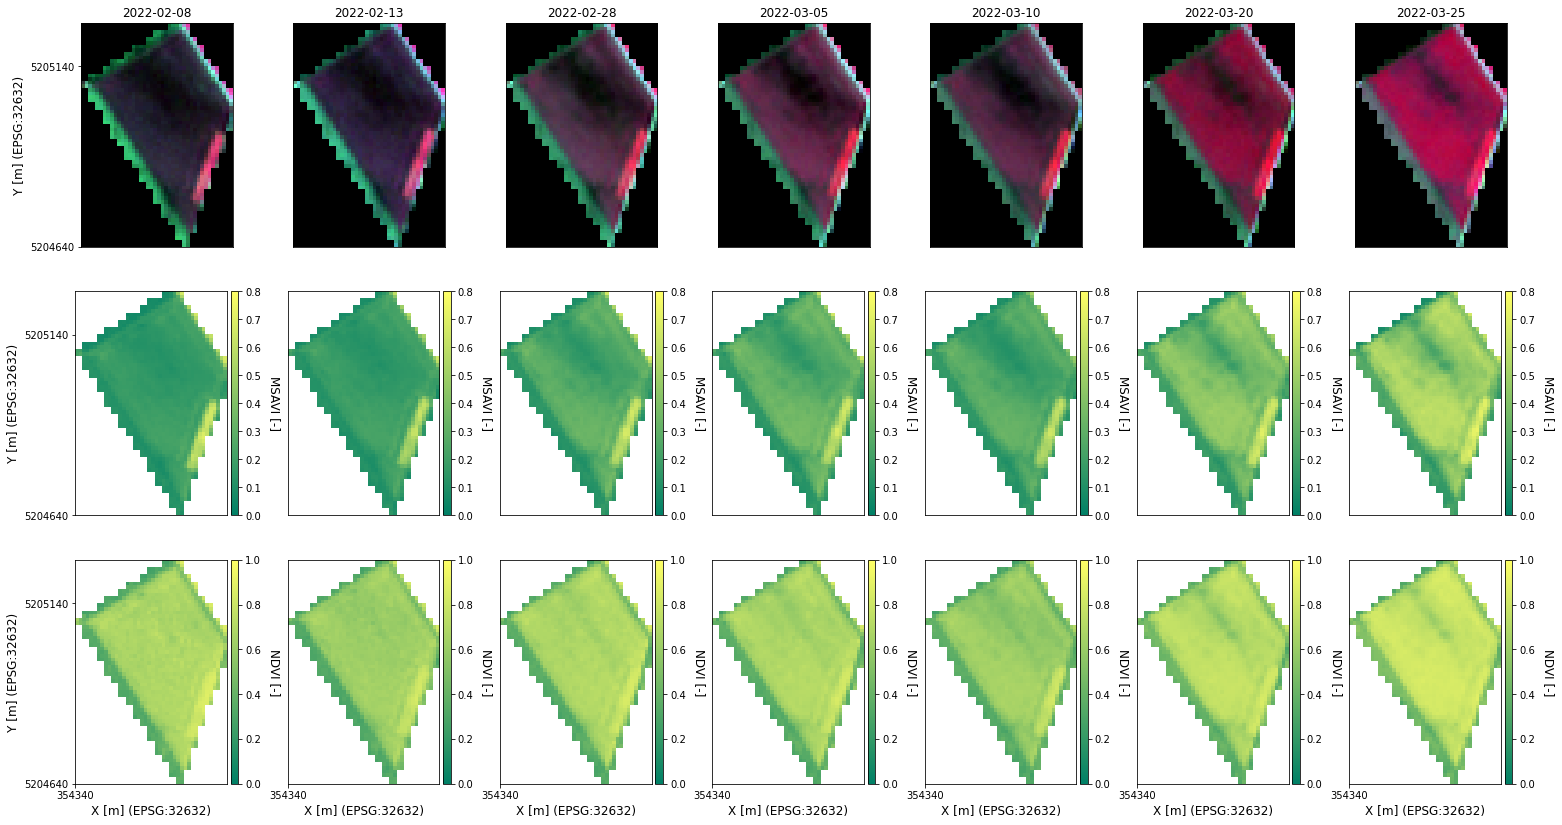

In [29]:
plot_images(res_s22)

Clearly, the false-color infra-red composite as well as the MSAVI values show less reddish and lower index values, respectively, in those central part of the field parcel most heavily affected by flooding in July the year before. In NDVI, the pattern is less clearly visible which relates to the aforementioned saturation problem.

### Pixel-based Plant Growth Assessment

The spatial pattern, which is well seen in the emergence behavior of winter wheat, can serve as a basis to extract vegetation time series for individual Sentinel-2 pixels. For this purpose, a pixel is selected which is located in the area most affected by the flooding and a pixel from the lower left (southwestern) part of the plot. These are called "flooded" and "unaffected" respectively.

In [31]:
pixels = gpd.read_file(base_dir.joinpath('data/sample_points/veg_points.gpkg'))
pixels.to_crs('EPSG:4326', inplace=True)

map = folium.Map([parcel_centroid.y, parcel_centroid.x], zoom_start=15, tiles="Stamen Terrain")
folium.GeoJson(data=parcel["geometry"]).add_to(map)
for i in range(len(pixels)):
   folium.Marker(
      location=[pixels.iloc[i]['geometry'].y, pixels.iloc[i]['geometry'].x],
      popup=pixels.iloc[i]['name'],
   ).add_to(map)

map

In order to study the differences between the two locations, the entire time series from summer 2021 to summer 2022 is extracted using AgriSatPy. AgriSatPy can use the pixel positions directly to extract the Sentinel-2 data from the archive.

In [32]:
res_complete = extract_s2_data(
    parcel=parcel,
    date_start=date(2021,3,1),
    date_end=date(2022,6,10)
)

2022-06-09 16:04:23,416 eodal        INFO     Feature 35: Extracted data from 2022-05-29 (1/54)
2022-06-09 16:04:27,097 eodal        INFO     Feature 35: Extracted data from 2022-05-24 (2/54)
2022-06-09 16:04:30,626 eodal        INFO     Feature 35: Extracted data from 2022-05-19 (3/54)
2022-06-09 16:04:34,511 eodal        INFO     Feature 35: Extracted data from 2022-05-14 (4/54)
2022-06-09 16:04:38,192 eodal        INFO     Feature 35: Extracted data from 2022-05-09 (5/54)
2022-06-09 16:04:42,286 eodal        INFO     Feature 35: Extracted data from 2022-05-04 (6/54)
2022-06-09 16:04:45,945 eodal        INFO     Feature 35: Extracted data from 2022-04-19 (7/54)
2022-06-09 16:04:49,345 eodal        INFO     Feature 35: Extracted data from 2022-04-14 (8/54)
2022-06-09 16:04:52,589 eodal        INFO     Feature 35: Extracted data from 2022-04-04 (9/54)
2022-06-09 16:04:55,190 eodal        INFO     Feature 35: Extracted data from 2022-03-25 (10/54)
2022-06-09 16:04:57,537 eodal        IN

In [33]:
records = []
for sensing_date in res_complete['feature_scenes'].keys():
    rec = res_complete['feature_scenes'][sensing_date].get_pixels(vector_features=pixels, band_selection=['NDVI','MSAVI'])
    rec['date'] = sensing_date
    records.append(rec)

# convert to single GeoDataFrame of the complete pixel time series
pixel_ts = pd.concat(records)
pixel_ts = pixel_ts.sort_values(by='date')
pixel_ts

,name,geometry,NDVI,MSAVI,date
1,unaffected,POINT (354604.246 5204865.774),NaN,NaN,2021-03-20
0,flooded,POINT (354523.891 5205122.347),NaN,NaN,2021-03-20
0,flooded,POINT (354523.891 5205122.347),0.267869,0.071731,2021-03-30
1,unaffected,POINT (354604.246 5204865.774),0.213992,0.071444,2021-03-30
1,unaffected,POINT (354604.246 5204865.774),0.249524,0.089339,2021-04-04
...,...,...,...,...,...
0,flooded,POINT (354523.891 5205122.347),0.845170,0.626482,2022-04-19
1,unaffected,POINT (354604.246 5204865.774),0.880403,0.763381,2022-05-14
0,flooded,POINT (354523.891 5205122.347),0.869674,0.692363,2022-05-14
1,unaffected,POINT (354604.246 5204865.774),0.915169,0.813082,2022-05-19


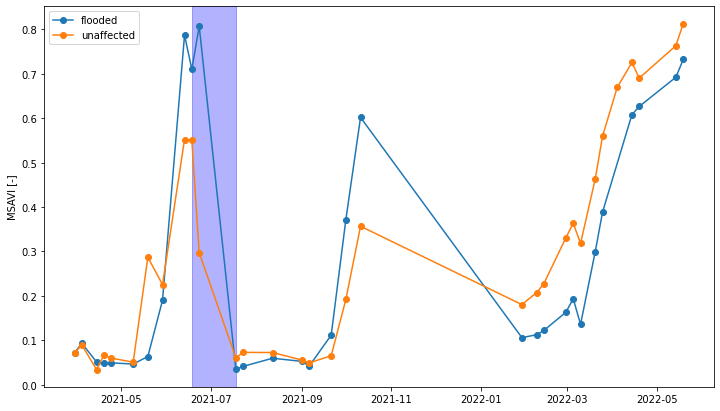

In [34]:
# plot the MSAVI and NDVI of the two pixels over time
flooded = pixel_ts[pixel_ts.name == 'flooded'].copy()
unaffected = pixel_ts[pixel_ts.name == 'unaffected'].copy()

f, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,7))
vi = 'MSAVI'

s1mask = np.isfinite(flooded[vi])
s2mask = np.isfinite(unaffected[vi])

axes.plot(flooded.date[s1mask], flooded[vi][s1mask], label='flooded', linestyle='-', marker='o')
axes.plot(unaffected.date[s2mask], unaffected[vi][s2mask], label='unaffected', linestyle='-', marker='o')
axes.legend()
axes.set_ylabel('MSAVI [-]')
axes.axvspan(date(2021,6,18), date(2021,7,18), alpha=0.3, color='blue')

The "flooded" (blue) and "unaffected" (orange) pixel clearly show different temporal trajectories in MSAVI. Before the flood (blue rectangle), the "flooded" pixel as higher MSAVI values than the "unaffected" pixel. After the flood event both pixels show very low MSAVI values close to zero. In autumn (October) 2021 regrowth occurs with the "flooded" pixel showing again higher MSAVI values than the "unaffected" pixel. In Spring 2022, the pattern changes, however, and reflects the results obtained from looking at the series of Sentinel-2 images: The "flooded" pixel constantly shows lower MSAVI values (i.e., less developed leaves and biomass values) than the "unaffected" pixel.

### Digital Terrain Model

To understand the causes of flooding and differences in plant growth, it helps to look at the Digital Elevation Model (DEM). This can be obtained from SwissTopo in 2m spatial resolution ([swissALTI3D](https://www.swisstopo.admin.ch/en/geodata/height/alti3d.html)).

Using the `STAC-API` of SwissTopo and `eodal` it is possible to access, merge and visualize the DEM covering the extent of the field parcel.

In [36]:
import json
import re
import requests
import urllib

from typing import Optional, Union
from eodal.core.band import Band
from eodal.operational.mapping.merging import merge_datasets

def query_DEM_tiles_STAC(
        bbox: np.array,
        base_url: str,
        spatial_resolution: Optional[str] = '2'
    ):
    """
    Returns links to tiles for a user-defined polygon from swissTopo using the
    STAC API. The geometry needs to be provided in geographic coordinates
    (WGS84) because the API only accepts this reference system.

    :param base_url:
        base URL of the STAC API endpoint for the swissALTI3D data. In Aug 2021 this was:
        https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissalti3d
    :param bbox:
        bounding box defining the spatial extent to download. Must be in geographic
        coordinates
    :param spatial_resolution:
        spatial resolution of the DEM product (0.5 or 2 meters)
    :returns:
        list of URLs of all those tiles covering the bounding box specified
    """
    # construct bbox specification required by STAC
    bbox_expr = f'{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}'
    # construct API GET call
    url = urllib.parse.urljoin(base_url, f'items?bbox={bbox_expr}')
    # send the request and check response code
    res_get = requests.get(url)
    res_get.raise_for_status()
    # get content and extract the tile URLs
    content = json.loads(res_get.content)
    features = content['features']
    files = []
    for feature in features:
        assets = feature['assets']
        tif_pattern = re.compile(r"^.*\.(tif)$")
        tif_files = [tif_pattern.match(key) for key in assets.keys()]
        tif_files =[x for x in tif_files if x is not None]
        tif_file = [x.string if x.string.find(f'_{spatial_resolution}_') > 0 \
                    else None for x in tif_files]
        tif_file = [x for x in tif_file if x is not None][0]
        # get download link
        link = assets[tif_file]['href']
        files.append(link)
    return files

def get_dem_tiles(
        polygon_feature: Union[Path, gpd.GeoDataFrame],
        **kwargs
    ):
    if isinstance(polygon_feature, Path):
        gdf = gpd.read_file(polygon_feature)
    elif isinstance(polygon_feature, gpd.GeoDataFrame):
        gdf = polygon_feature.copy()
    else:
        raise TypeError()
    # re-project to geographic coordinates and get total bounds
    gdf_wgs84 = gdf.to_crs(epsg=4326)
    bbox = gdf_wgs84.geometry.total_bounds

    # query STAC API endpoint to get list of URLs with tiles matching
    # the queried spatial extent (bbox)
    url_list = query_DEM_tiles_STAC(bbox=bbox, **kwargs)
    return merge_datasets(
        datasets=url_list,
        vector_features=polygon_feature
    )


In [37]:
# download tiles from SwissTopo (using STAC)
base_url = 'https://data.geo.admin.ch/api/stac/v0.9/collections/ch.swisstopo.swissalti3d/'
dtm = get_dem_tiles(
        polygon_feature=parcel,
        base_url=base_url
)
# re-project into UTM Zone 32 N to match the CRS of the Sentinel-2 data
dtm.reproject(target_crs=32632, inplace=True)
# re-project the two sample pixels
pixels.to_crs('EPSG:32632', inplace=True)

Text(0.5, 1.0, 'Digital Elevation Model (SwissTop)')

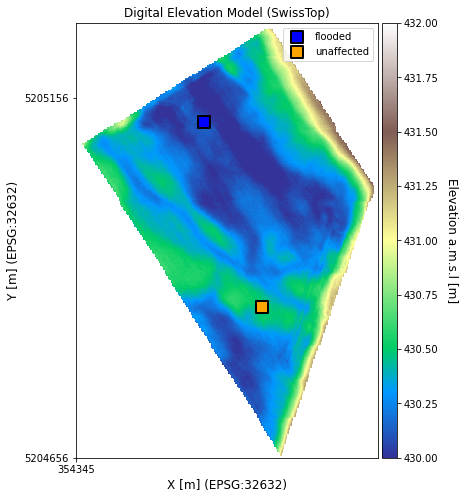

In [38]:
# plot DTM and pixels on it
fig_dtm = plt.figure(figsize=(10,8))
ax = fig_dtm.add_subplot(111)
_ = dtm['B1'].plot(colormap='terrain', colorbar_label='Elevation a.m.s.l [m]', vmin=430, vmax=432, ax=ax)

flooded_pix = pixels[pixels.name == 'flooded'].geometry
unaffected_pix = pixels[pixels.name == 'unaffected'].geometry
ax.scatter(flooded_pix.x, flooded_pix.y, color='blue', label='flooded', s=150, marker='s', linewidths=2, edgecolor='black')
ax.scatter(unaffected_pix.x, unaffected_pix.y, color='orange', label='unaffected', s=150, marker='s', linewidths=2, edgecolor='black')
ax.legend()
ax.set_title('Digital Elevation Model (SwissTop)')

Looking at the high-resolution topography data from SwissTopo shows that the "flooded" pixel (blue) lies in a depression, whereas the "unaffected" pixel is located at slightly higher elevation.

In more detail the height difference can be assessed using `AgriSatPy`:

In [39]:
elev = dtm.get_pixels(vector_features=pixels)
elev.rename(columns={'B1':'Elevation [m]'}, inplace=True)
elev

,name,geometry,Elevation [m]
0,flooded,POINT (354523.891 5205122.347),430.111786
1,unaffected,POINT (354604.246 5204865.774),430.477020


Thus, the difference in elevation between the "flooded" and the "unaffected" pixel is less than 0.5 m. Still, in the flat terrain this small difference has a huge on plant growth as was shown when looking at the Sentinel-2 derived vegetation time series of the two pixels.

## Bringing Everything Together - Qualitative Assessment

The Sentinel-2 data, the DTM, and the meteo data together can now help to qualitatively understand the impact of the flooding:

Those areas of the parcel that have slightly lower elevation (as seen in the DTMs, the parcel is considered "flat" overall) match very well with the areas that appear to be impacted in the satellite data image. More, the spring 2022 field survey showed growth differences that can be reconciled with the previous year's flooding, the DTM data, and the spring Sentinel-2 data. With the knowledge of the problem of soil subsidence in the region and the heavy rainfall in the previous summer, the qualitative analysis presented here can be used to show very well the impact of these circumstances on the development of agricultural crops.

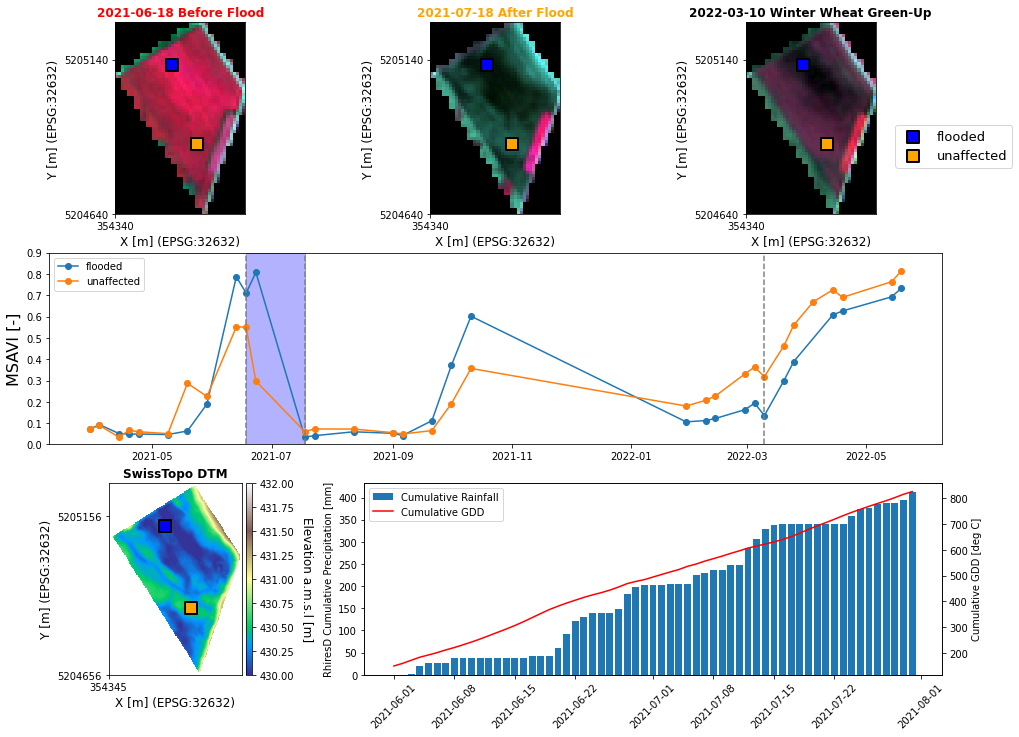

In [40]:
# open figure for plotting
fig = plt.figure(figsize=(16,12))
gs = fig.add_gridspec(ncols=3, nrows=3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, :])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1:])

# S2 before flood
res_s21['feature_scenes'][date(2021,6,18)].plot_multiple_bands(['nir_1', 'red', 'green'], ax=ax1)
ax1_title = ax1.set_title('2021-06-18 Before Flood')
ax1.scatter(flooded_pix.x, flooded_pix.y, color='blue', label='flooded', s=150, marker='s', linewidths=2, edgecolor='black')
ax1.scatter(unaffected_pix.x, unaffected_pix.y, color='orange', label='unaffected', s=150, marker='s', linewidths=2, edgecolor='black')
plt.setp(ax1_title, color='red', fontweight='bold')

# S2 after flood
res_s21['feature_scenes'][date(2021,7,18)].plot_multiple_bands(['nir_1', 'red', 'green'], ax=ax2)
ax2_title = ax2.set_title('2021-07-18 After Flood')
ax2.scatter(flooded_pix.x, flooded_pix.y, color='blue', label='flooded', s=150, marker='s', linewidths=2, edgecolor='black')
ax2.scatter(unaffected_pix.x, unaffected_pix.y, color='orange', label='unaffected', s=150, marker='s', linewidths=2, edgecolor='black')
plt.setp(ax2_title, color='orange', fontweight='bold')

# S2 spring 2022
res_s22['feature_scenes'][date(2022,3,10)].plot_multiple_bands(['nir_1', 'red', 'green'], ax=ax3)
ax3_title = ax3.set_title('2022-03-10 Winter Wheat Green-Up')
ax3.scatter(flooded_pix.x, flooded_pix.y, color='blue', label='flooded', s=150, marker='s', linewidths=2, edgecolor='black')
ax3.scatter(unaffected_pix.x, unaffected_pix.y, color='orange', label='unaffected', s=150, marker='s', linewidths=2, edgecolor='black')
plt.setp(ax3_title, fontweight='bold')
ax3.legend(bbox_to_anchor=(1.1, 0.5), fontsize=13)

# time series of selected pixels
ax4.plot(flooded.date[s1mask], flooded[vi][s1mask], label='flooded', linestyle='-', marker='o')
ax4.plot(unaffected.date[s2mask], unaffected[vi][s2mask], label='unaffected', linestyle='-', marker='o')
ax4.legend()
ax4.set_ylabel('MSAVI [-]', fontsize=16)
ax4.axvspan(date(2021,6,18), date(2021,7,18), alpha=0.3, color='blue')
ax4.vlines(date(2021,6,18), ymin=0, ymax=0.9, linestyle='dashed', color='grey')
ax4.vlines(date(2021,7,18), ymin=0, ymax=0.9, linestyle='dashed', color='grey')
ax4.vlines(date(2022,3,10), ymin=0, ymax=0.9, linestyle='dashed', color='grey')
ax4.set_ylim(0, 0.9)

# elevation
dtm['B1'].plot(colormap='terrain', colorbar_label='Elevation a.m.s.l [m]', ax=ax5, vmin=430, vmax=432)
ax5_title = ax5.set_title('SwissTopo DTM')
plt.setp(ax5_title, fontweight='bold')
ax5.scatter(flooded_pix.x, flooded_pix.y, color='blue', label='flooded', s=150, marker='s', linewidths=2, edgecolor='black')
ax5.scatter(unaffected_pix.x, unaffected_pix.y, color='orange', label='unaffected', s=150, marker='s', linewidths=2, edgecolor='black')

# meteo
ax6.bar(x=meteo['Date'], height=meteo['cumulative precipitation'], label='Cumulative Rainfall')
ax6_2 = ax6.twinx()
ax6_2.plot(meteo['Date'], meteo['cumulative GDD'], color='red', label='Cumulative GDD')
_ = plt.setp(ax6.get_xticklabels(), rotation=45)
ax6.set_ylabel('RhiresD Cumulative Precipitation [mm]')
ax6_2.set_ylabel('Cumulative GDD [deg C]')
lines, labels = ax6.get_legend_handles_labels()
lines2, labels2 = ax6_2.get_legend_handles_labels()
ax6.legend(
    lines + lines2, labels + labels2,
)

In [41]:
# save figure to dislk
out_dir = base_dir.joinpath('img')
out_dir.mkdir(exist_ok=True)

fname = out_dir.joinpath('S2_Flood_Crop_Growth_Example')
fig.savefig(fname, bbox_inches='tight')

## Quantitative Assessment

A first quantitative assessment could include the quantification of the area affected by flooding using simple spectral index thresholds.

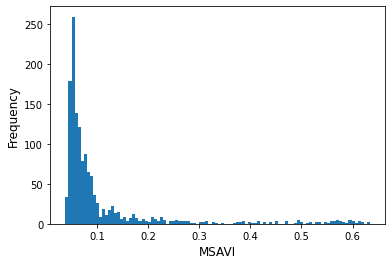

In [42]:
msavi = res_s21['feature_scenes'][date(2021,7,23)]['MSAVI']
hist_msavi = msavi.hist(bins=100)

Using a threshold of 0.06 in MSAVI a delineation can be made between areas affected by flooding and those showing less impact:

In [43]:
# mask the MSAVI values greater than 0.06
msavi_mask = msavi > 0.06
msavi_masked = msavi.mask(mask=msavi_mask.values)

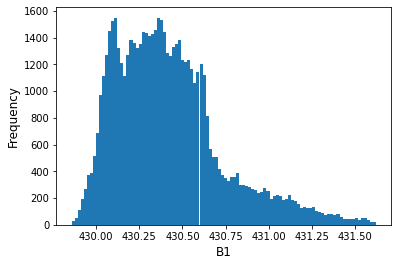

In [44]:
hist_dtm = dtm['B1'].hist(bins=100)

In a similar way, the 430.25 m elevation mark can be used:

In [45]:
# mask DTM values greater tham 430.3 meters
elev = dtm['B1']
dtm_mask = elev > 430.25
dtm_masked = elev.mask(mask=dtm_mask.values)

Text(0.5, 1.0, 'MSAVI')

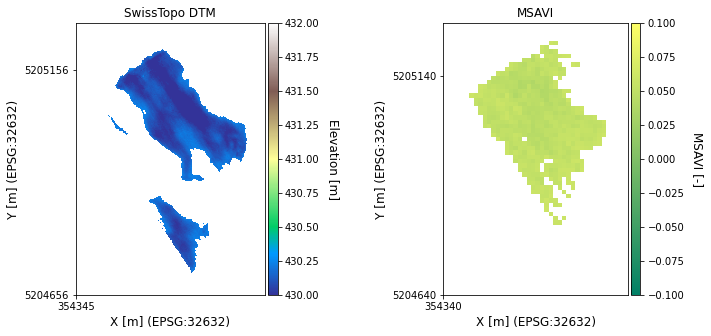

In [46]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
_ = dtm_masked.plot(colormap='terrain', colorbar_label='Elevation [m]', ax=ax[0], vmin=430, vmax=432)
ax[0].set_title('SwissTopo DTM')
_ = msavi_masked.plot(colormap='summer', colorbar_label='MSAVI [-]', ax=ax[1])
ax[1].set_title('MSAVI')

The segmented area from the DTM (left) and MSAVI (right) show correspondence in their areal extent. Using the pixel size of these data sources (2 m in case of the DTM data, 10 m for MSAVI), the area affected by flooding can be calculated (in square meters):

In [47]:
msavi_flooded = np.count_nonzero(~np.isnan(msavi_masked.values)) * msavi_masked.geo_info.pixres_x**2
dtm_low_elev = np.count_nonzero(~np.isnan(dtm_masked.values)) * dtm_masked.geo_info.pixres_x**2

In [48]:
res = [{'Source': 'MSAVI', 'Area sqm': msavi_flooded}, {'Source': 'DTM', 'Area sqm': dtm_low_elev}]
pd.DataFrame(res)

,Source,Area sqm
0,MSAVI,140000.000000
1,DTM,243096.043403


The area derived from MSAVI (140000 sqm) is smaller than the value based on thresholding the terrain data (243096 sqm). The difference can be explained by the fact that in the lower left corner of the field in the DTM data there is also a dip, which however does not show the same effect in the MSAVI as in the larger dip in the center of the field, which can be seen in both data sources.

It has to be said that the threshold values are chosen somewhat arbitrarily and more work would be needed to make the approach robust. However, the main point here is to show the capabilities of AgriSatPy than to provide a methodologically perfect workflow.

# Conclusion

We were able to qualitatively demonstrate the effects of soil subsidence and flooding on plant growth using a simple example, and make an initial rough quantitative estimate of the area affected.

The approach shown here is of course still highly simplified to its execution. Further analyses would therefore be necessary for a quantitative and deeper investigation of the phenomenon presented here. However, we could show that it is possible to perform explorative spatial data analysis using `AgriSatPy` and to intersect different geodata sources with satellite data. In addition, `AgriSatPy`'s API allows for problem-specific customizations.